# Midterm Project
Written by John Carlsson & Lukas Runt for Social network Analysis spring 2023
The tasks are as follows:

# Task 1
Implement, if necessary, optimized versions of the social network mining algorithms seen during the course (diameter, triangles computation, clustering) and test these algorithms on the following datasets:
Facebook large
High-energy physics theory citation

In [ ]:
# Task 1:
import networkx as nw
from joblib import Parallel, delayed, cpu_count
import pandas as pd
import itertools as it
import math
from scipy.sparse import linalg
import random
from sklearn.cluster import SpectralClustering
import numpy as np

def diameter(G:nw.graph, sample = None):
    nodes=G.nodes()
    n = len(nodes)
    diam = 0
    if sample is None:
        sample = nodes

    for u in sample:
        udiam=0
        clevel=list()
        clevel.append(u)
        visited=set()
        visited.add(u)
        while len(visited) < n:
            nlevel=[]
            while(len(clevel) > 0):
                c=clevel.pop()
                for v in G[c]:
                    if v not in visited:
                        visited.add(v)
                        nlevel.append(v)
            clevel = nlevel
            udiam += 1
        if udiam > diam:
            diam = udiam
    return diam

def chunks(data, size):
    idata=iter(data)
    for i in range(0, len(data), size):
        yield {k:data[k] for k in it.islice(idata, size)} 
def parallel_diam(G,j = cpu_count()):
    diam = 0
    # Initialize the class Parallel with the number of available process
    with Parallel(n_jobs=j) as parallel:
        
        #Run in parallel diameter function on each processor by passing to each processor only the subset of nodes on which it works
        result=parallel(delayed(diameter)(G, X) for X in chunks(G.nodes(), math.ceil(len(G.nodes())/j)))
        #Aggregates the results
        diam = max(result)
    return diam

def less(G, edge):
    if G.degree(edge[0]) < G.degree(edge[1]):
        return 0
    if G.degree(edge[0]) == G.degree(edge[1]) and edge[0] < edge[1]:
        return 0
    return 1
def triangles(G:nw.Graph):
    num_triangles = 0
    m = nw.number_of_edges(G)

    # The set of heavy hitters, that is nodes with degree at least sqrt(m)
    # Note: the set contains at most sqrt(m) nodes, since num_heavy_hitters*sqrt(m) must be at most the sum of degrees = 2m
    # Note: the choice of threshold sqrt(m) is the one that minimize the running time of the algorithm.
    # A larger value of the threshold implies a faster processing of triangles containing only heavy hitters, but a slower processing of remaining triangles.
    # A smaller value of the threshold implies the reverse.
    heavy_hitters=set()
    for u in G.nodes():
        if G.degree(u) >= math.sqrt(m):
            heavy_hitters.add(u)

    # Number of triangles among heavy hitters.
    # It considers all possible triples of heavy hitters, and it verifies if it forms a triangle.
    # The running time is then O(sqrt(m)^3) = m*sqrt(m)
    for triple in it.combinations(heavy_hitters,3):
        if G.has_edge(triple[0],triple[1]) and G.has_edge(triple[1], triple[2]) and G.has_edge(triple[0], triple[2]):
            num_triangles+=1

    # Number of remaining triangles.
    # For each edge, if one of the endpoints is not an heavy hitter, verifies if there is a node in its neighborhood that forms a triangle with the other endpoint.
    # This is essentially the naive algorithm optimized to count only ordered triangle in which the first vertex (i.e., u) is not an heavy hitter.
    # Since the size of the neighborhood of a non heavy hitter is at most sqrt(m), the complexity is O(m*sqrt(m))
    for edge in G.edges():
        sel=less(G,edge)
        if edge[sel] not in heavy_hitters:
            for u in G[edge[sel]]:
                if less(G,[u,edge[1-sel]]) and G.has_edge(u,edge[1-sel]):
                    num_triangles +=1

    return num_triangles

def spectral_clustering(G:nw.Graph):
    adj_mat = nw.to_numpy_array(G) # Returns an adj_matrix
    sc = SpectralClustering(2, affinity='precomputed', n_init=100, assign_labels='discretize')
    sc.fit(adj_mat)


    return sc.labels_


G_fb = nw.Graph()
for edge in pd.read_csv('facebook_large/musae_facebook_edges.csv').values:
    G_fb.add_edge(*edge) 


#print(parallel_diam(G_fb)) # Takes around 10 min to run, returns the longest shortest path for the graph. It's 15
#print(triangles(G_fb)) # Takes 1 second, return the number of unique triangles in the graph: it's 797516
spec_labels = spectral_clustering(G_fb) # Divides the graph into two subgraphs, works by magic, returns labels of the cluster assign to the node, 10 min

print(len(spec_labels))

# Task 2
Implement the shapley-closeness centrality measure as defined in Michalack et al. (JAIR 2013) sec. 4.4.
Implement, if necessary, optimized versions of all studied centrality measures (degree, closeness, betweenness, PageRank, HITS-authority, HITS-hubiness, HITS-both, voterank, shapley-degree, shapley-threshold, shapley-closeness) and test them on the datasets indicated in Task1.
The goal of this task is to shortlists the set of centrality measures based on efficiency and similarity of outcomes. Indeed, in the final project you may need to use centrality measures. This task has the goal to shortlist the set of measures that you will use in the final task.

In [ ]:
# Task 2
import networkx as nw
import pandas as pd


def shapley_closeness(G:nw.Graph, f = lambda x: 1/(x+1)):

    sv = {i:0 for i in G.nodes()}

    for v in G.nodes(): # Parallelise this
        print(v)
        djk_len = nw.single_source_dijkstra_path_length(G,v) # returns dict with nodes as key and distance as value
        djk_len = dict(sorted(djk_len.items(), key=lambda x:x[1])) # Sorted dictionary in ascending order
        index_list = list(djk_len.keys().__reversed__()) # sorted in decreasing order and the items are node names
        distance = list(djk_len.values().__reversed__())
        sum = 0
        
        prevDistance = -1
        prevSV = -1
        for index, name in enumerate(index_list, start = 1): # go through the nodes starting with the ine furthest away, index 0
            
            if distance[index-1] == prevDistance:
                currSV = prevSV
            else:
                currSV = f(distance[index-1])/(1+index) - sum
            sv[name] += currSV
            sum += f(distance[index-1])/(index*(1+index))
            prevDistance = distance[index-1]
            prevSV = currSV
        sv[v] = f(0) - sum
        
    return sv

G_fb = nw.Graph()
for edge in pd.read_csv('facebook_large/musae_facebook_edges.csv').values:
    G_fb.add_edge(*edge) 


shapley_values = shapley_closeness(G_fb)


In [ ]:
G_fb = nw.Graph()
import math
for edge in pd.read_csv('facebook_large/musae_facebook_edges.csv').values:
    G_fb.add_edge(*edge) 

v = G_fb.number_of_nodes()
e = G_fb.number_of_edges()
print(v*e+v**2*math.log(v))

# Task 3


Implement the VCG, the MUDAN, and the MUDAR, for selling multiple homogeneous items on a social network, with each agent only requiring a single item. The MUDAN and MUDAR algorithm are available on (Fang et al., 2023).

In [ ]:
# Task 3
def auction(k:int, seller_net:list, reports:dict, bids:dict, type = 'vcg'):
    """ This code assumes that one bidder can be assigned one item
- k, is the number of items to sell;

- seller_net, is a set of strings each identifying a different bidder;

- reports, is a dictionary whose keys are strings each identifying a different bidder and whose
    values are sets of strings representing the set of bidders to which the bidder identified by the
    key reports the information about the auction;

- bids, is a dictionary whose keys are strings each identifying a different bidder and whose
    values are numbers defining the bid of the bidder identified by that key.

- type is the type of auction that is taking place

Returns:
- allocation, that is a dictionary that has as keys the strings identifying each of the bidders
that submitted a bid, and as value a boolean True if this bidder is allocated one of the items,
and False otherwise.

- payments, that is a dictionary that has as keys the strings identifying each of the bidders that
submitted a bid, and as value the price that she pays. Here, a positive price means that the bidder
is paying to the seller, while a negative price means that the seller is paying to the bidder.
    """
   
    allocation, payments = dict(), dict()

    for p in bids:
        bids[p] = [random.randint(0, 1000) for x in range(k)]

    sw = list(map(sum, zip(*[bids[i] for i in bids])))

        # return allocation, payments


def allocation(k, bids):
    # initialization, one bidder can win many items
    allocation = {}
    for bidder in bids:
        allocation[bidder] = False

    for x in range(k):
        winner = list(bids)[0]
        for bidder in bids:
            if bids[bidder][x] > bids[winner][x]:
                winner = bidder
        allocation[winner] = True

    return allocation


def vcg():
    pass

if __name__ == "__main__":
    k = 10
    seller_net = ["player " + str(x) for x in range(1, 11)]
    # keys inentifying bidder,
    reports = {}
    bids = {}
    for s in seller_net:
        nei = [random.randint(0, len(seller_net) - 1) for i in range(random.randint(0, len(seller_net) - 1))]
        reports[s] = [seller_net[x] for x in nei if seller_net[x] != s]
        bid = [0] * k
        for i in range(k):
            bid[i] = random.randint(0, 100)
        bids[s] = bid

    print(seller_net)
    print(reports)
    print(bids)

    print(allocation(k, bids))
    auction(3, seller_net, reports, bids)

    type = 'vcg'


# Task 4


Implement an environment for bandits algorithm that will model the following setting:
We are given a social network such that with a probability p(u,v) for each edge (u,v). These probabilities are unknown to the learner. The learner at each time steps interacts with this environment by choosing a vertex x. The environment set each edge (u,v) as alive with probability p(u,v), and dead otherwise. It then assigns as a reward to the learner that is equivalent to the number of nodes of the social network that are reachable from the selected vertex x through alive edges only.
Given that the goal of the auctioneer is to maximize her cumulative reward, find the best bandit algorithm (either found among the ones implemented during the course, or a completely new designed algorithm) that the auctioneer may use in above setting (i.e., the algorithm must decide which vertex to select at each time step).


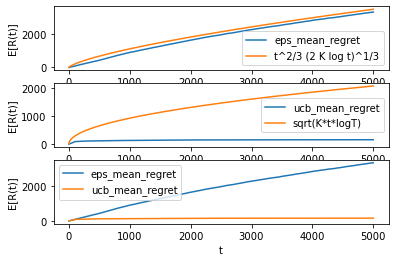

In [16]:
import networkx as nw
import math
import random
import matplotlib.pyplot as plt
class Environment:
    #We initialise the environment, keep or remove the edges (dead or alive) based on the prbability
    def __init__(self, g:nw.Graph, p = 0.3):
        prob = {i:random.random() for i in g.edges}
        for edge in prob:
            if prob[edge] > p: g.remove_edge(*edge)

        self.rewards = {i:len(nw.descendants(g,i)) for i in g.nodes()}

    #It select the reward for the given arm according to the distribution with the given mean
    def receive_reward(self, arm):

        return self.rewards[arm]


class UCB_Learner:

    def __init__(self, arms_set, T, environment:Environment): #USE THIS FOR KNOWN TIME HORIZON
    #def __init__(self, arms_set, environment): #USE THIS FOR UNKNOWN TIME HORIZON
        self.__arms_set = arms_set #initialize the set of arms
        self.__environment = environment #initialize the environment
        self.__T = T #COMMENT THIS FOR UNKNOWN TIME HORIZON
        #self.__t = 1 #UNCOMMENT THIS FOR UNKNOWN TIME HORIZON
        # Next initialization will serve for computing the best strategy during exploitation steps
        self.__num = {a:0 for a in arms_set} #It saves the number of times arm a has been selected
        self.__rew = {a:0 for a in arms_set} #It saves the cumulative reward achieved by arm a when selected
        #It saves the ucb value of each arm until the current time step
        #It is initialised to infinity in order to allow that each arm is selected at least once
        self.__ucb = {a:float('inf') for a in arms_set}

    # This function returns the arm chosen by the learner and the corresponding reward returned by the environment
    def play_arm(self):
        a_t = max(self.__ucb, key=self.__ucb.get)  #We choose the arm that has the highest average revenue

        reward = self.__environment.receive_reward(a_t) #We save the reward assigned by the environment
        # We update the number of times arm a_t has been chosen, its cumulative reward and its UCB value
        self.__num[a_t] += 1
        self.__rew[a_t] += reward
        #COMMENT THE FOLLOWING LINE FOR UNKNOWN TIME HORIZON
        self.__ucb[a_t] = self.__rew[a_t]/self.__num[a_t] + math.sqrt(2*math.log(self.__T)/self.__num[a_t])
        #UNCOMMENT THE FOLLOWING LINES FOR UNKNOWN TIME HORIZON
        #self.__ucb[a_t] = self.__rew[a_t] / self.__num[a_t] + math.sqrt(2 * math.log(self.__t) / self.__num[a_t])
        #self.__t += 1

        return a_t, reward


class EpsGreedy_Learner:
    def __init__(self, arms_set, T, environment:Environment, eps): #USE THIS FOR KNOWN TIME HORIZON
    #def __init__(self, arms_set, environment, eps): #USE THIS FOR UNKNOWN TIME HORIZON
        self.__arms_set = list(arms_set) #initialize the set of arms
        self.__environment = environment #initialize the environment
        self.__T = T #COMMENT THIS FOR UNKNOWN TIME HORIZON
        self.__eps = eps #initialize the sequence of eps_t
        #Next initialization will serve for computing the best strategy during exploitation steps
        self.__num = {a:0 for a in arms_set} #It saves the number of times arm a has been selected
        self.__rew = {a:0 for a in arms_set} #It saves the cumulative reward achieved by arm a when selected
        self.__avgrew = {a:0 for a in arms_set}  #It saves the average reward achieved by arm a until the current time step
        self.__t = 0 #It saves the current time step

    #This function returns the arm chosen by the learner and the corresponding reward returned by the environment
    def play_arm(self):
        a_t = max(self.__avgrew, key=self.__avgrew.get) #We choose the arm that has the highest average revenue
        
        r = random.random()
        if r <= self.__eps[self.__t]: #With probability eps_t
        #if r <= self.__eps(self.__t): USE THIS FOR UNKNOWN TIME HORIZON
            a_t = random.choice(self.__arms_set) #We choose an arm uniformly at random

        reward = self.__environment.receive_reward(a_t) #We save the reward assigned by the environment
        #We update the number of times arm a_t has been chosen, its cumulative and its average reward
        self.__num[a_t] += 1
        self.__rew[a_t] += reward
        self.__avgrew[a_t] = self.__rew[a_t] / self.__num[a_t]
        self.__t += 1 #We are ready for a new time step

        return a_t, reward
    
# If we want to make our own learner
class NodeLearner:
    def __init__(self, arms_set, T, environment:Environment): #USE THIS FOR KNOWN TIME HORIZON
    #def __init__(self, arms_set, environment, eps): #USE THIS FOR UNKNOWN TIME HORIZON
        self.__arms_set = list(arms_set) #initialize the set of arms
        self.__environment = environment #initialize the environment
        self.__T = T #COMMENT THIS FOR UNKNOWN TIME HORIZON
        
    #This function returns the arm chosen by the learner and the corresponding reward returned by the environment
    def play_arm(self):
        pass
        #reward = self.__environment.receive_reward(a_t) #We save the reward assigned by the environment
        #We update the number of times arm a_t has been chosen, its cumulative and its average reward
        
        #return a_t, reward
    
if __name__ == '__main__':
    #INITIALIZATION
    # Generate a graph
    
    g = nw.gnp_random_graph(100, 1, directed=True)

    # probability of edge being dead
    p = 0.5
    
       
    
    
    #Optimal Arm in Hindsight: I need it for computing the regret
    
    #Time Horizon
    T = 5000
    #We would like to evaluate the expected regret with respect to t
    #To this aim, we cannot just run a single simulation:
    #the result can be biased by extreme random choices (of both the environment and the learner)
    #For this reason we run N simulations,
    #and we will evaluate against t the average regret over the N simulations
    #To this aim, we define N, and we will record for each learner a matrix containing
    #the regret for each simulation and each time step within the simulation
    N = 50 #number of simulations
    eps = [1] #for the first step we cannot make exploitation, so eps_1 = 1
    eps.extend((len(g.nodes())*math.log(t)/t)**(1/3) for t in range(2,T+1))
    ucb_regrets = {n: {t: 0 for t in range(T)} for n in range(N)} #regret matrix for the UCB learner
    eps_regrets = {n: {t: 0 for t in range(T)} for n in range(N)} #regret matrix for the UCB learner
    

   #SIMULATION PLAY
    for n in range(N):
        ucb_cum_reward = 0 #it saves the cumulative reward of the UCB learner
        eps_cum_reward = 0 #it saves the cumulative reward of the eps-greedy learner
        cum_opt_reward = 0 #it saves the cumulative reward of the best-arm in hindsight
        
        #Environment
        env = Environment(g)
        opt_a = max(env.rewards,key = env.rewards.get) # Optimal arm
        #Eps-Greedy Learner
        eps_learn = EpsGreedy_Learner(g.nodes(), T, env, eps) #COMMENT FOR UNKNOWN TIME HORIZON
        #eps_learn = EpsGreedy_Learner(arms_set, env, eps) #UNCOMMENT FOR UNKNOWN TIME HORIZON
        #UCB Learner
        ucb_learn = UCB_Learner(g.nodes(), T, env)  #COMMENT FOR UNKNOWN TIME HORIZON
        #ucb_learn = UCB_Learner(arms_set, env)  #UNCOMMENT FOR UNKNOWN TIME HORIZON
        for t in range(T):
            #reward obtained by the optimal arm
            cum_opt_reward += env.receive_reward(opt_a)
            
            # reward obtained by the ucb learner
            a, reward = ucb_learn.play_arm()
            ucb_cum_reward += reward
            #regret of the ucb learner
            ucb_regrets[n][t] = cum_opt_reward - ucb_cum_reward
            #reward obtained by the eps_greedy learner
            a, reward = eps_learn.play_arm()
            eps_cum_reward += reward
            #regret of the eps_greedy learner
            eps_regrets[n][t] = cum_opt_reward - eps_cum_reward

    #compute the mean regret of the eps greedy and ucb learner
    eps_mean_regrets = {t:0 for t in range(T)}
    ucb_mean_regrets = {t:0 for t in range(T)}
    for t in range(T):
        eps_mean_regrets[t] = sum(eps_regrets[n][t] for n in range(N))/N
        ucb_mean_regrets[t] = sum(ucb_regrets[n][t] for n in range(N))/N

    #VISUALIZATION OF RESULTS
    #compute t^2/3 (c K log t)^1/3
    ref_eps = list()
    for t in range(1, T+1):
        ref_eps.append((t**(2/3))*(2*len(g.nodes())*math.log(t))**(1/3))

    #compute c*sqrt(KtlogT)
    ref_ucb = list()
    for t in range(1, T+1):
        ref_ucb.append(math.sqrt(len(g.nodes())*t*math.log(T)))

    fig, (ax1, ax2, ax3) = plt.subplots(3)
    #Plot eps-greedy regret against its reference value
    ax1.plot(range(1,T+1), eps_mean_regrets.values(), label = 'eps_mean_regret')
    ax1.plot(range(1,T+1), ref_eps, label = f't^2/3 (2 K log t)^1/3')
    ax1.set_xlabel('t')
    ax1.set_ylabel('E[R(t)]')
    ax1.legend()

    #Plot ucb regret against its reference value
    ax2.plot(range(1,T+1), ucb_mean_regrets.values(), label = 'ucb_mean_regret')
    ax2.plot(range(1,T+1), ref_ucb, label = f'sqrt(K*t*logT)')
    ax2.set_xlabel('t')
    ax2.set_ylabel('E[R(t)]')
    ax2.legend()

    #Plot ucb regret against eps-greedy regret
    ax3.plot(range(1,T+1), eps_mean_regrets.values(), label = 'eps_mean_regret')
    ax3.plot(range(1,T+1), ucb_mean_regrets.values(), label = 'ucb_mean_regret')
    ax3.set_xlabel('t')
    ax3.set_ylabel('E[R(t)]')
    ax3.legend()

    plt.show()
